In [ ]:
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

import gensim.downloader
from gensim.models import Word2Vec, KeyedVectors
from natasha import Doc, Segmenter, MorphVocab, NewsEmbedding, NewsMorphTagger

import mlxtend
from mlxtend.evaluate import paired_ttest_kfold_cv

from plotly.offline import iplot
import cufflinks as cf
!pip install gensim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import datetime
from wordcloud import WordCloud, STOPWORDS
from google.colab import drive

import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")

sns.set(style="darkgrid")
%matplotlib inline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [ ]:
!pip install natasha

In [ ]:
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/Collab/datasett.csv')


print(f'Размер датасета: {df.shape}')
df.head()

In [ ]:
RND_STATE = 73

751

In [ ]:
segmenter = Segmenter()
morh_vocab = MorphVocab()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)

In [ ]:
def text_prep(text) -> str:
    doc = Doc(text)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)

    for token in doc.tokens:
        token.lemmatize(morh_vocab)

    lemmas = [_.lemma for _ in doc.tokens]
    words = [lemma for lemma in lemmas if lemma.isalpha() and len(lemma) > 2]
    filtered_words = [word for word in words if word not in stop_words]
    return " ".join(filtered_words)

In [ ]:
%%time
df['content'] = df.content.apply(text_prep)

CPU times: user 35.1 s, sys: 20.2 s, total: 55.4 s
Wall time: 32.7 s


In [ ]:
df['content'][1]

'февраль россия отмечать день победа сталинградский битва мир день сурок православный веровать вспоминать евфимий лик лента рассказывать праздник отмечать февраль год россия страна знаменитость родиться день праздник россия праздник мирекака церковный праздник сегодняпримет февралякто родиться февраляпраздник россия день разгром советский войско войско сталинградский битвефонтан бармалей привокзальный площадь сталинград август годафото эммануил евзерихин риа новостисталинградский битва начаться июль год закончиться февраль год поражение фашистский блок сталинград подорвать доверие германия сторона союзник способствовать активизация движение сопротивление страна европа день буква относительно новый буква русский алфавит греческий азбука позаимствовать больший часть буква отсутствовать древний кириллический текст xiv век иметь собственный начертание записываться ерь ера приписать буква слитный написание полноценный статус буква приобрести поздний текст праздник миредень суркафото barry r

In [ ]:
model = Word2Vec(sentences=df.content.str.split(),
                 vector_size=200,
                 min_count=10,
                 window=2,
                 seed=RND_STATE)

In [ ]:
model.wv.most_similar(positive=["заявить"])  #можно посмотреть и даже поэксперементировать

[('переговоры', 0.9995509386062622),
 ('американский', 0.9995319843292236),
 ('власть', 0.9995073080062866),
 ('бывший', 0.9994899034500122),
 ('подчеркнуть', 0.999484658241272),
 ('мнение', 0.999477744102478),
 ('администрация', 0.9994760155677795),
 ('хотеть', 0.9994701743125916),
 ('предложить', 0.9994678497314453),
 ('страна', 0.999463677406311)]

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(df.content.str.split(), df.tag.values, random_state=RND_STATE)

model = Word2Vec(sentences=X_train,
                 vector_size=200,
                 min_count=10,
                 window=2,
                 seed=RND_STATE)

In [ ]:
class MeanEmbeddingVectorizer(object):

  def __init__(self,model):
    self.word2vec = model.wv
    self.dim = model.vector_size

  def fit(self, X, y):
    return self

  def transform(self, X):
    return np.array([
        np.mean([self.word2vec.get_vector(w)
          for w in words if w in self.word2vec] or
          [np.zeros(self.dim)], axis=0)
        for words in X
    ])


In [ ]:
pipe = Pipeline([('w2v', MeanEmbeddingVectorizer(model)),
                 ('clf', LogisticRegression(max_iter=1000, random_state=RND_STATE))])
pipe.fit(X_train, Y_train)

print(classification_report(Y_test, pipe.predict(X_test)))

                   precision    recall  f1-score   support

      Бывший СССР       0.00      0.00      0.00        30
    Забота о себе       0.00      0.00      0.00         6
         Из жизни       0.00      0.00      0.00         4
   Интернет и СМИ       0.00      0.00      0.00        12
         Культура       0.00      0.00      0.00         1
              Мир       0.32      0.96      0.48        57
  Наука и техника       0.00      0.00      0.00        10
      Путешествия       0.00      0.00      0.00         5
           Россия       0.07      0.03      0.04        33
Силовые структуры       0.00      0.00      0.00         7
            Спорт       0.00      0.00      0.00         8
         Ценности       0.00      0.00      0.00         5
        Экономика       0.00      0.00      0.00        10

         accuracy                           0.30       188
        macro avg       0.03      0.08      0.04       188
     weighted avg       0.11      0.30      0.15      

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [ ]:
class TfidfEmbeddingVectorizer(object):

  def __init__(self, model):
    self.word2vec = model.wv
    self.word2weight = None
    self.dim = model.vector_size

  def fit(self, X, y):
    tfidf = TfidfVectorizer(analyzer=lambda x: x)
    tfidf.fit(X)

    max_idf = max(tfidf.idf_)
    self.word2weight = defaultdict(lambda: max_idf, [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

    return self

  def transform(self, X):
    return np.array([
            np.mean([self.word2vec.get_vector(w) * self.word2weight[w]
                    for w in words if w in self.word2vec] or
                  [np.zeros(self.dim)], axis=0)
          for words in X
    ])

In [ ]:
pipe = Pipeline([('w2v', TfidfEmbeddingVectorizer(model)),
                 ('clf', LogisticRegression(random_state=RND_STATE, max_iter=10000))])

pipe.fit(X_train, Y_train)

print(classification_report(Y_test, pipe.predict(X_test)))

                   precision    recall  f1-score   support

      Бывший СССР       0.00      0.00      0.00        30
    Забота о себе       0.00      0.00      0.00         6
         Из жизни       0.00      0.00      0.00         4
   Интернет и СМИ       0.00      0.00      0.00        12
         Культура       0.00      0.00      0.00         1
              Мир       0.35      0.95      0.51        57
  Наука и техника       0.00      0.00      0.00        10
      Путешествия       0.00      0.00      0.00         5
           Россия       0.34      0.33      0.34        33
Силовые структуры       0.00      0.00      0.00         7
            Спорт       0.00      0.00      0.00         8
         Ценности       0.00      0.00      0.00         5
        Экономика       0.00      0.00      0.00        10

         accuracy                           0.35       188
        macro avg       0.05      0.10      0.07       188
     weighted avg       0.17      0.35      0.21      

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



<Axes: >

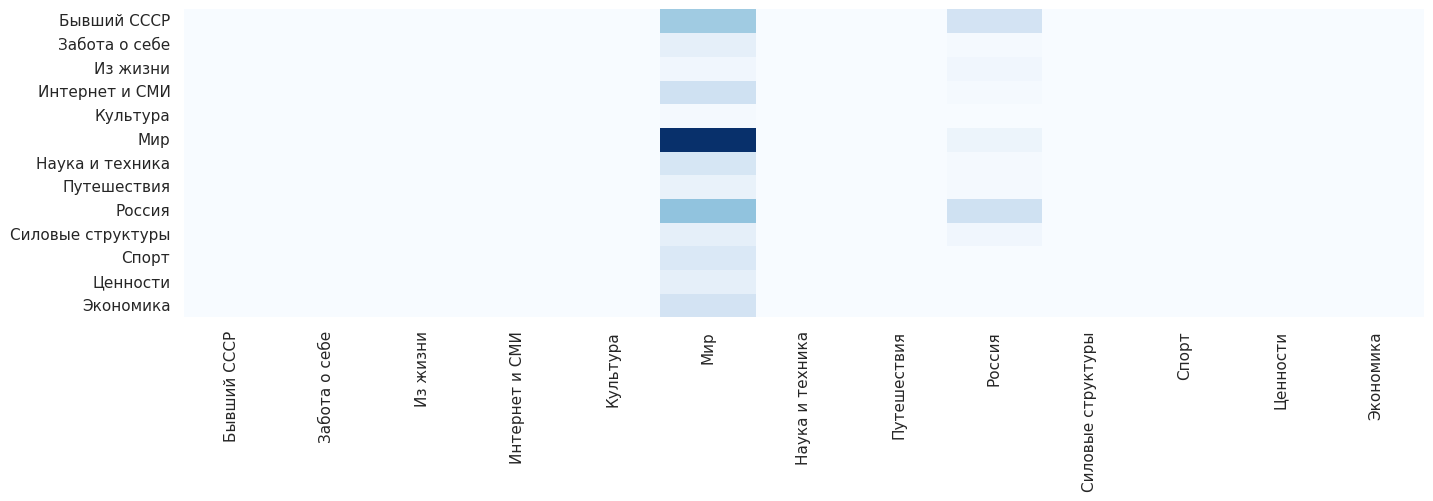

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(Y_test, pipe.predict(X_test), labels = pipe.classes_)

cm_df = pd.DataFrame(data=cm, columns = pipe.classes_, index=pipe.classes_)

plt.figure(figsize=(16, 4))

sns.heatmap(cm_df, square=False, annot=False, cmap='Blues', fmt='d', cbar=False)